In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import requests
from io import BytesIO
import scanpy as sc
import os
import seaborn as sns
#sns.set(rc={'figure.figsize':(20,40)})
sc.settings.verbosity = 3           # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#sc.settings.set_figure_params(dpi=80, facecolor='white')
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi'] = 100

2021-11-03 17:19:34.822866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 17:19:34.822893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.1 anndata==0.7.6 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 pynndescent==0.5.5


### Lectura de datos y AED
**scanpy** tiene algunos metodos muy utiles para laburar con data de scRNA-seq asi que conviene primero tener la matriz como un objeto AnnData para poder usarlos y despues pasar a un dataframe para seguir con pandas, matplotlib, etc

In [2]:
#Links a los dataset en Dropbox
url_labels = "https://www.dropbox.com/s/k52estyk8x858jt/Labels_train.csv?dl=1"
url_dataset = "https://www.dropbox.com/s/lt46bxixojo4qwb/training_set.csv.gz?dl=1"

In [3]:
def leer_data(url_dataset, url_target):
    '''Lee el dataset y los targets'''
    
    
    targets = pd.read_csv(url_labels)
    
    url_file = requests.get(url_dataset, stream=True)
    f=BytesIO(url_file.raw.read())
    
    with gzip.open(f) as file:
        gziped_file = gzip.GzipFile(fileobj=f)
        data = pd.read_csv(gziped_file, index_col=0)

    
    return data, targets


In [4]:
#Necesito al menos 32GB de RAM
"""
#Cargar data en memoria si no esta
try:
    #Tratar de cargar data del cache
    %store -r X_train
    %store -r t_train
    #Chequear que esten cargados
    X_train
    t_train
except NameError:
    print('Los datos no estan cargados. Se van a cargar ahora')
    X_train, t_train = leer_data(url_dataset, url_labels)
    #Guardar en cache para la proxima sesion
    %store X_train
    %store t_train
"""

"\n#Cargar data en memoria si no esta\ntry:\n    #Tratar de cargar data del cache\n    %store -r X_train\n    %store -r t_train\n    #Chequear que esten cargados\n    X_train\n    t_train\nexcept NameError:\n    print('Los datos no estan cargados. Se van a cargar ahora')\n    X_train, t_train = leer_data(url_dataset, url_labels)\n    #Guardar en cache para la proxima sesion\n    %store X_train\n    %store t_train\n"

In [5]:
#If 16GB or less RAM
X_train, t_train = leer_data(url_dataset, url_labels)

In [6]:
#Para trabajar con los metodos de scanpy
X_train_annData = sc.AnnData(X_train)
#Guardo la info de los targets en el AnnData para despues
t_train.index = X_train_annData.obs.index
X_train_annData.obs['CellTypes'] = t_train['x']


In [7]:
#Normalizacion por CPM y log1p de la data
sc.pp.normalize_total(X_train_annData, target_sum=1e6, exclude_highly_expressed = True)
#sc.pp.log1p(X_train_annData) #para el tSNE

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A8', 'TMSB4X', 'MALAT1', 'FTL', 'IGLL5', 'MT.CO1']
    finished (0:00:00)


computing PCA
    with n_comps=50
    finished (0:00:23)


/home/lucas/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellTypes' as categorical


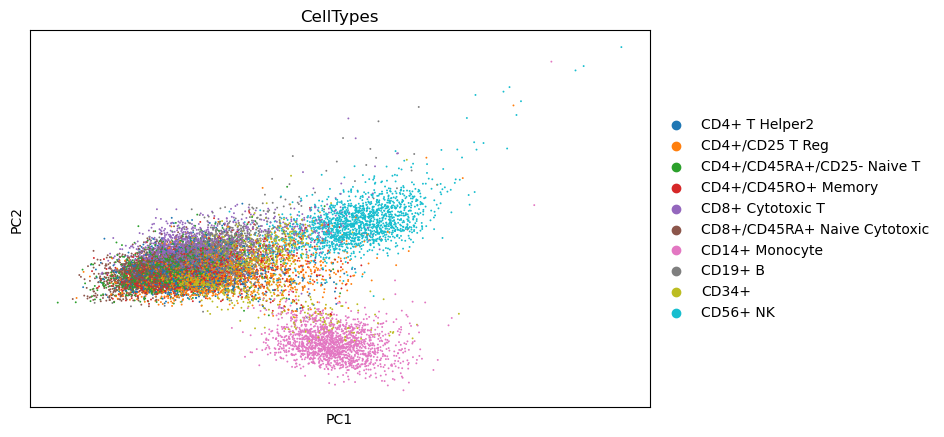

In [8]:
#Los resultados del pca (PCs y pesos) se guardan en X_train_annData.varm y X_train_annData.obsm
sc.tl.pca(X_train_annData, svd_solver='arpack', n_comps = 50)
sc.pl.pca(X_train_annData, color = "CellTypes")

In [9]:
X_train = X_train_annData.to_df()

In [10]:
X_train.shape

(16000, 21952)

## Pre-procesado 

### Reduccion dimensional pre-analisis 

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [12]:
#Scale Gene Expression
scaler = MinMaxScaler()
X_train_MMscaled = scaler.fit_transform(X_train)

In [13]:
print(X_train.iloc[300:320,1449:1452])
print(X_train_MMscaled[300:320,1449:1452])

                    KRTCAP2  TRIM46  MUC1
AACTGTCTTCTAGG     0.000000     0.0   0.0
CTTCATGATGCTCC   409.836060     0.0   0.0
TCGACGCTCTGAGT     0.000000     0.0   0.0
GCAACCCTCAGATC     0.000000     0.0   0.0
TACGGCCTAACGAA     0.000000     0.0   0.0
CCACCATGAGTCGT     0.000000     0.0   0.0
TTCGGAGATCACCC     0.000000     0.0   0.0
AACAAACTCAATCG     0.000000     0.0   0.0
CGACGTCTACTCTT     0.000000     0.0   0.0
GAGGTTTGGTACAC  1834.862305     0.0   0.0
CACAACGAGTCTGA     0.000000     0.0   0.0
ATACAATGTGTGAC  1111.111084     0.0   0.0
TAGCTACTGTTGAC   802.568176     0.0   0.0
TCCGGACTCTGAGT   807.754456     0.0   0.0
TCGTTATGCACTAG     0.000000     0.0   0.0
TATCGACTTGCTAG     0.000000     0.0   0.0
ATTCAGCTCCTATT   924.214417     0.0   0.0
TAGTGGTGAATGCC     0.000000     0.0   0.0
GCCTCAACGACTAC     0.000000     0.0   0.0
TATCGTACCCTTTA     0.000000     0.0   0.0
[[0.         0.         0.        ]
 [0.11290984 0.         0.        ]
 [0.         0.         0.        ]
 [0.      

In [14]:
my_model = PCA(n_components=7000)
X_train_MMscaled_PCA = my_model.fit_transform(X_train_MMscaled)
print(X_train.shape)
print(t_train.shape)

(16000, 21952)
(16000, 1)


In [15]:
var = my_model.explained_variance_ratio_.cumsum()*100
X_train.shape

(16000, 21952)

In [16]:
print(X_train_MMscaled_PCA.shape)

(16000, 7000)


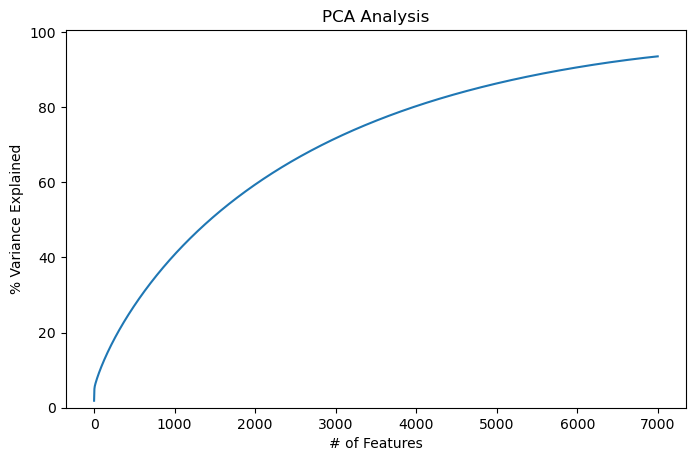

In [17]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

In [18]:
#Checking var
var[4999]

86.33313

In [19]:
print(X_train_MMscaled_PCA.shape)
print(X_train.shape)

(16000, 7000)
(16000, 21952)


## Implementacion de RandomForest


In [20]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

In [21]:
t_train = t_train["x"]
t_train.shape

(16000,)

## RandomForest Funciona con 0.84 en Crossval

In [22]:
%%time
dt = RandomForestClassifier(n_estimators=2500, max_leaf_nodes= 300,
min_samples_leaf= 5, n_jobs= -2)
cross_dt = cross_val_score(dt,X_train,t_train, scoring='accuracy')

CPU times: user 1min 6s, sys: 6.29 s, total: 1min 13s
Wall time: 7min


In [23]:
np.mean(cross_dt)

0.8415624999999999

## Other Tries

In [42]:
%%time
rf = RandomForestClassifier(n_jobs=-1)
params={'n_estimators':[1000,2000,2500,3000],'min_samples_leaf':[5,10,20,30], 'max_leaf_nodes':[50,75,100,200,300]}
grilla = GridSearchCV(rf,params,cv=8,scoring='accuracy', n_jobs=-1)
grilla.fit(X_train,t_train)

CPU times: user 20min 54s, sys: 1.33 s, total: 20min 55s
Wall time: 8h 47min 36s


GridSearchCV(cv=8, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_leaf_nodes': [50, 75, 100, 200, 300],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'n_estimators': [1000, 2000, 2500, 3000]},
             scoring='accuracy')

In [54]:
grilla.refit_time_

78.39959812164307

In [48]:
#print(np.mean(cross_val_score(grilla, X_train, t_train,scoring='accuracy')))

In [49]:
grilla.best_estimator_

RandomForestClassifier(max_leaf_nodes=300, min_samples_leaf=5,
                       n_estimators=2500, n_jobs=-1)

In [44]:
modelo_rf=grilla.best_estimator_

In [22]:
%%time
rf2 = RandomForestClassifier(n_jobs=-1)
params2={'n_estimators':[2500],'min_samples_leaf':[2,5,10],'max_depth':[30,50,120], 'max_leaf_nodes':[200,300,350]}
grilla2 = RandomizedSearchCV(rf2,params2,cv=5,scoring='accuracy', n_jobs=-1)
grilla2.fit(X_train,t_train)

CPU times: user 21min 27s, sys: 1.49 s, total: 21min 28s
Wall time: 56min 9s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'max_depth': [30, 50, 120],
                                        'max_leaf_nodes': [200, 300, 350],
                                        'min_samples_leaf': [2, 5, 10],
                                        'n_estimators': [2500]},
                   scoring='accuracy')

In [23]:
grilla2.best_params_

{'n_estimators': 2500,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 350,
 'max_depth': 50}

In [30]:
grilla2.best_score_

0.8383749999999999

## AdaBoostClassifier

In [13]:
%%time
#AdaBoostClassifier(base_estimator=SVC/DT/Perceptron/RL,n_estimator= cuantos voy a considerar, algorithm=que algoritmo uso, learning_rate = ,...)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=0.01)
params3={'n_estimators':[500,1000,1500,2000,3000]}
grilla_ada = GridSearchCV(ada_clf,params3,cv=5,scoring='accuracy', n_jobs=-2)

grilla_ada.fit(X_train,t_train)

CPU times: user 1h 3min 31s, sys: 819 ms, total: 1h 3min 31s
Wall time: 4h 21min 14s


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.01),
             n_jobs=-2,
             param_grid={'n_estimators': [500, 1000, 1500, 2000, 3000]},
             scoring='accuracy')

In [19]:
grilla_ada.best_score_

0.6663125

In [58]:
cross_ada_clf = cross_val_score(ada_clf,X_train,t_train, scoring='accuracy')

In [59]:
cross_ada_clf

array([0.7128125, 0.723125 , 0.6815625, 0.728125 , 0.6996875])

## Adaboost with transformed data

In [15]:
%%time
n_estimators=1000
#AdaBoostClassifier(base_estimator=SVC/DT/Perceptron/RL,n_estimator= cuantos voy a considerar, algorithm=que algoritmo uso, learning_rate = ,...)
t_ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators, learning_rate=0.01)

t_ada_clf.fit(X_transf,t_train)


NameError: name 'X_transf' is not defined

In [62]:
t_cross_ada_clf = cross_val_score(t_ada_clf,X_transf,t_train, scoring='accuracy')
t_cross_ada_clf

array([0.6728125, 0.6665625, 0.66125  , 0.699375 , 0.6778125])

## Red Neuronal

In [24]:
import tensorflow as tf
from tensorflow import keras

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [26]:
#Convert labels to numbers
code = np.array(t_train)
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(code)
vec_t=vec.T
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train_MMscaled_PCA,vec,test_size=0.3)
#Transform numbers to 0 and 1 vector
y_train_c = tf.keras.utils.to_categorical(y_train_, 10)
y_valid_c = tf.keras.utils.to_categorical(y_valid_, 10)

In [66]:
keras.backend.clear_session()

In [67]:
#input_ = keras.layers.Input(shape=X_train.shape[1:])
#hidden1 = keras.layers.Dense(500, activation="relu",kernel_initializer="he_normal")(input_)
#hidden2 = keras.layers.Dense(650, activation="relu",kernel_initializer="he_normal")(hidden1)
#hidden3 = keras.layers.Dense(200, activation="relu",kernel_initializer="he_normal")(hidden2)
#output = keras.layers.Dense(10, activation='softmax')(hidden3)
#model = keras.models.Model(inputs=[input_], outputs=[output])

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train_MMscaled_PCA.shape[1:]),
    keras.layers.Dense(15, activation="relu",kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(20, activation="relu",kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(15, activation="relu",kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7000)              0         
_________________________________________________________________
dense (Dense)                (None, 15)                105015    
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0

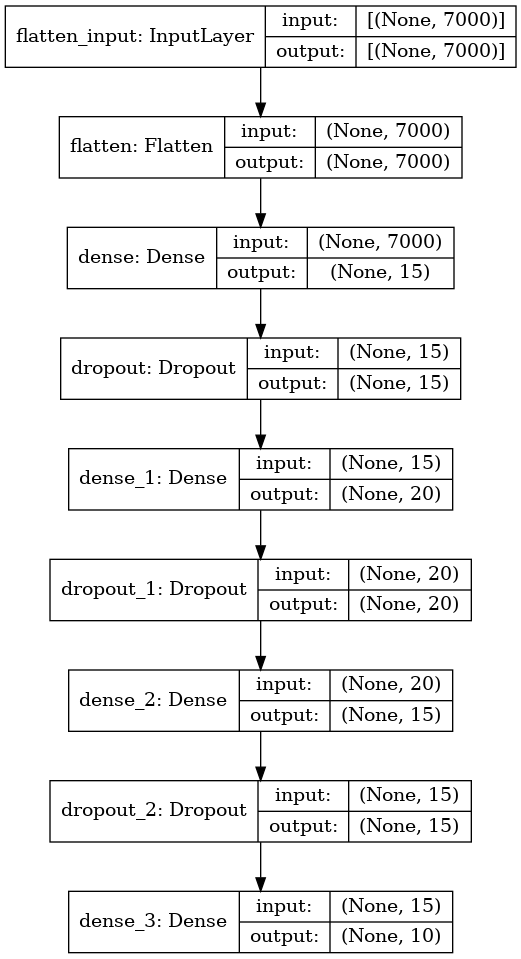

In [69]:
keras.utils.plot_model(model,show_shapes=True)

In [70]:
print(y_valid_[:10])
print(y_valid_c[:10])
print(y_valid_.shape)
print(X_valid_.shape)
print(y_train_.shape)

[4 2 1 3 1 4 3 4 7 1]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(4800,)
(4800, 7000)
(11200,)


In [71]:
#model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy', keras.metrics.Recall(class_id=5)])
#history = model.fit(X_train_,y_train_,validation_data=(X_valid_,y_valid_),callbacks=[early_stopping_cb],batch_size=1000,epochs=500)
#history = model.fit(epochs=250, batch_size=32, x=X_train_, y=y_train_c, validation_data=(X_valid_,y_valid_c),callbacks=[early_stopping_cb])

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=2e-3),
              metrics=["accuracy"])
early_stopping_cb=keras.callbacks.EarlyStopping(patience=30)
history = model.fit(X_train_, y_train_c, epochs=500, validation_data=(X_valid_,y_valid_c),callbacks=[early_stopping_cb], batch_size=32)

Epoch 1/500
350/350 [==============================] - 1s 1ms/step - loss: 2.2942 - accuracy: 0.1202 - val_loss: 2.2842 - val_accuracy: 0.1567
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 2.2752 - accuracy: 0.1392 - val_loss: 2.2558 - val_accuracy: 0.2292
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 2.2471 - accuracy: 0.1734 - val_loss: 2.2154 - val_accuracy: 0.3042
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 2.2064 - accuracy: 0.2150 - val_loss: 2.1617 - val_accuracy: 0.3694
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 2.1593 - accuracy: 0.2447 - val_loss: 2.0940 - val_accuracy: 0.4048
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 2.0960 - accuracy: 0.2736 - val_loss: 2.0101 - val_accuracy: 0.4112
Epoch 7/500
350/350 [==============================] - 0s 1ms/step - loss: 2.0360 - accuracy: 0.2779 - val_loss: 1.9195 - val_accuracy: 0.4156

/tmp/ipykernel_2261/249833518.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.01)


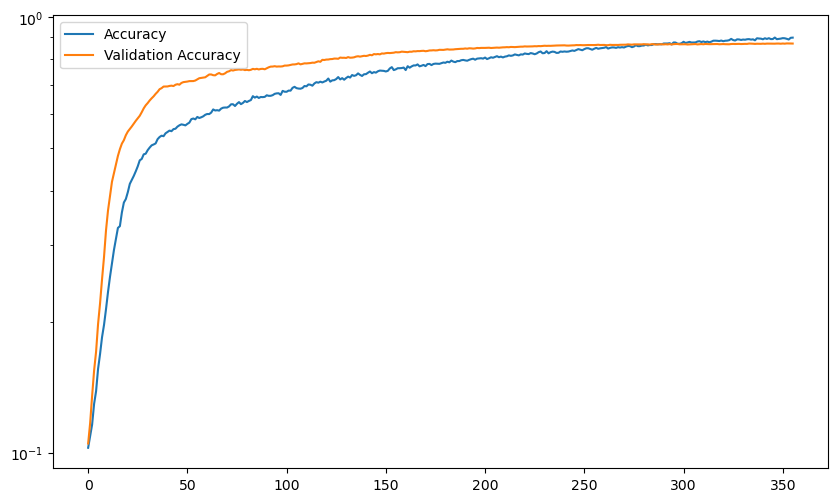

In [59]:
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['accuracy'], label='Accuracy')
plt.semilogy(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0,1.01)
plt.legend(loc=0)